# Confiabilidade de viga mista

## Importando bibliotecas

In [628]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from math import sqrt
import pandas as pd

## Tabela de perfis

In [629]:
tabela = pd.read_excel('Catalogo-Tabela-Bitolas-Editado-2.xlsx')
display(tabela)

,massa_linear,d,bf,tw,tf,h,d',area,Ix,Wx,...,ly,Wy,ry,Zy,rt,lt,Mesa,Alma,Cw,u\n
0,13.0,148,100,4.3,4.9,138,118,16.6,635,85.8,...,82,16.4,2.22,25.5,2.60,1.72,10.20,27.49,4181,0.67
1,18.0,153,102,5.8,7.1,139,119,23.4,939,122.8,...,126,24.7,2.32,38.5,2.69,4.34,7.18,20.48,6683,0.69
2,22.5,152,152,5.8,6.6,139,119,29.0,1229,161.7,...,387,50.9,3.65,77.9,4.10,4.75,11.52,20.48,20417,0.88
3,24.0,160,102,6.6,10.3,139,115,31.5,1384,173.0,...,183,35.9,2.41,55.8,2.73,11.08,4.95,17.48,10206,0.69
4,29.8,157,153,6.6,9.3,138,118,38.5,1739,221.5,...,556,72.6,3.80,110.8,4.18,10.95,8.23,17.94,30277,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,154.2,623,229,14.0,24.9,573,541,196.5,125783,4038.0,...,4999,436.6,5.04,683.3,5.94,303.29,4.60,38.66,4456995,2.11
104,155.0,611,324,12.7,19.0,573,541,198.1,129583,4241.7,...,10783,665.6,7.38,1022.6,8.53,200.77,8.53,42.60,9436714,2.47
105,174.0,616,325,14.0,21.6,573,541,222.8,147754,4797.2,...,12374,761.5,7.45,1171.1,8.58,286.88,7.52,38.63,10915665,2.48
106,195.0,622,327,15.4,24.4,573,541,250.1,168484,5417.5,...,14240,870.9,7.55,"1341 ,0",8.66,405.29,6.70,35.14,12695302,2.49


## Definindo funções

In [630]:
def calculo_destribuicao_media(media: float, desvpad: float, area: bool = False) -> list:
    AMOSTRAS: int = 10000
    medias: list = []
    areas: list = []
    
    if (area):
        for i in range(AMOSTRAS):
            numero_aleatorio: float = np.random.rand()
            medias.append(norm.ppf(numero_aleatorio, media, desvpad))
            areas.append(np.pi * (medias[i] / 2) ** 2)
        
        return medias, areas

    else:
        for i in range(AMOSTRAS):
            numero_aleatorio: float = np.random.rand()
            medias.append(norm.ppf(numero_aleatorio, media, desvpad))
            
        return medias
        

## Médias - Espessura da laje

In [631]:
espessura_laje: float = 10 # cm 
desvpad_espessura_laje: float = 0.06 * espessura_laje # cm

espessuras_laje: list = calculo_destribuicao_media(espessura_laje, desvpad_espessura_laje)

## Médias - Limite de escoamento do perfil de aço

In [632]:
limite_escoamento_perfil: float = 250 * 1.08 # MPa
desvpad_escoamento_perfil: float = 0.08 * limite_escoamento_perfil # MPa

limites_escoamento_perfil: list = calculo_destribuicao_media(limite_escoamento_perfil, desvpad_escoamento_perfil)

## Médias - Limite de escoamento da armadura

In [633]:
limite_escoamento_armadura: float = 500 * 1.08 # MPa
desvpad_escoamento_armadura: float = 0.05 * limite_escoamento_armadura #MPa

limites_escoamento_armadura: list = calculo_destribuicao_media(limite_escoamento_armadura, desvpad_escoamento_armadura)

## Médias - Resistência do concreto à compressão

In [ ]:
resistencia_concreto: float = 20 * 1.17 # MPa
desvpad_resistencia_concreto: float = 0.15 * resistencia_concreto # MPa

resistencias_concreto: list = calculo_destribuicao_media(resistencia_concreto, desvpad_resistencia_concreto)

## Médias - Diamêtro do rebite

In [ ]:
diametro_rebite: float = 1.59 # cm
desvpad_diametro_rebite: float = 0.01 * diametro_rebite # cm

diametros_rebites, areas_rebites = calculo_destribuicao_media(diametro_rebite, desvpad_diametro_rebite, True)


## Médias - Resistência do rebite

In [ ]:
resistencia_rebite: float = 415 * 1.06 # MPa
desvpad_resistencia_rebite: float = 0.06 * resistencia_rebite # MPa

resistencias_rebite: list = calculo_destribuicao_media(resistencia_rebite, desvpad_resistencia_rebite)

## Pré-dimensionamento

In [ ]:
carga_permanente_g1: float = 7.6 # kN/m
carga_permanente_g2: float = 5 # kN/m

variacao_carga: list = [9, 18]
carga_utilizacao_q2: list = [i for i in range(variacao_carga[0], variacao_carga[1])]

carga_construcao_q1: list = [i / 5.6 for i in carga_utilizacao_q2]

# Propriedades da laje
vao_laje: float = 9 # m
espacamento_laje: float = 2.8 # m

# Carga distrubuída do projeto
carga_distribuida_projeto: list = [1.4 * (carga_permanente_g1 + carga_permanente_g2) + carga_construcao_q1[i] * carga_utilizacao_q2[i] for i in range(len(carga_utilizacao_q2))]

# Momento solicitante do projeto
momentos_solicitante_projeto: list = [(carga_distribuida_projeto[i] * (vao_laje ** 2)) / 8 for i in range(len(carga_distribuida_projeto))]

altura_perfil_ht: float = 45 # cm
coeficiente_ya1: float = 1.1
x: float = 10 # cm

# Tabela com áreas filtradas a partir de 450 mm
tabela_filtrada = tabela.loc[tabela['d'] >= 450]

row_tabela: int = 0

# Área mínima da seção de aço
areas_minimas: list = [[] for i in range(len(momentos_solicitante_projeto))]
index_matriz: int = 0
area_minima_inicial: float = tabela_filtrada.iloc[0]['area']
for i in momentos_solicitante_projeto:
    for j in range(len(limites_escoamento_perfil)):
        areas_minimas[index_matriz].append((i * 100) / (((limites_escoamento_perfil[j] / 10) / coeficiente_ya1) * ((altura_perfil_ht / 2) + espessuras_laje[j] - (x / 2)))) # cm²
        if (areas_minimas[index_matriz][j] > area_minima_inicial):
            # print(f'Área mínima inicial: {area_minima_inicial}')
            # print(f'Área mínima calculada: {areas_minimas[index_matriz][j]}')
            if row_tabela < 1:
                row_tabela += 1
            area_minima_inicial = tabela_filtrada.iloc[row_tabela]['area']
    index_matriz += 1
    

print(f'Áreas mínimas: {areas_minimas}')
print(f'Área mínima final: {area_minima_inicial}')


Áreas mínimas: [[50.726246073500896, 48.31975892606441, 46.46781414227686, 52.77315155020332, 47.98016580675615, 52.75860297629643, 45.929708594720644, 40.86354172006306, 62.36475338721396, 46.78549518917884, 54.87812742862114, 45.959903428374346, 48.20108118239472, 50.747747101900025, 52.48852501996427, 51.14550813135065, 49.934295783224975, 41.51766809602632, 49.88248165747254, 44.51480295261667, 48.333687141368564, 50.986797084967215, 51.56110886378562, 48.391655380866595, 47.00689685987198, 45.85869723280346, 48.08721732018356, 44.03598822826414, 55.65430767162567, 46.316599698314086, 51.41252521795405, 47.59345210784629, 49.99676337421292, 48.332044368368514, 47.82409297109171, 45.164668802601525, 44.91226291902672, 47.24042935361372, 47.36627358757896, 55.42198847354817, 49.71739250994835, 45.524486820767834, 42.70070519540191, 55.474604318542596, 48.27060087948791, 50.45852308301091, 52.87575255751569, 52.081627972530455, 39.62097948660221, 54.52791414232541, 51.86389739001244, 

## Flambagem da seção

In [ ]:
# Classificação da seção quanto a flambagem
altura_perfil: float = tabela_filtrada.iloc[row_tabela]['d\''] # mm
altura_total_perfil: float = tabela_filtrada.iloc[row_tabela]['d'] # mm
altura_efetiva_perfil: float = tabela_filtrada.iloc[row_tabela]['h'] # mm
espessura_perfil: float = tabela_filtrada.iloc[row_tabela]['tw'] # mm
espessura_mesa: float = tabela_filtrada.iloc[row_tabela]['tf'] # mm
largura_mesa: float = tabela_filtrada.iloc[row_tabela]['bf'] # mm
modulo_elasticidade_perfil: float = 200000 # MPa
print(f'Altura perfil: {altura_perfil}, Altura total do perfil: {altura_total_perfil} e Espessura do perfil: {espessura_perfil}')

esbeltez_alma: float = altura_perfil / espessura_perfil

limites_flambagem_local: list = []

def calculo_limite_flambagem_local(coef: float, modulo_elasticidade_perfil: float, limite_escoamento_perfil: float) -> float:
    return coef * sqrt(modulo_elasticidade_perfil / limite_escoamento_perfil)

contador_compacto: int = 0
contador_semicompacto: int = 0

for i in range(len(limites_escoamento_perfil)):
    limite = calculo_limite_flambagem_local(3.76, modulo_elasticidade_perfil, limites_escoamento_perfil[i])
    limites_flambagem_local.append(limite)
    
    if esbeltez_alma <= limite:
        contador_compacto += 1
    elif esbeltez_alma > limite and esbeltez_alma < calculo_limite_flambagem_local(5.7, modulo_elasticidade_perfil, limites_escoamento_perfil[i]):
        contador_semicompacto += 1
    else:
        print('Erro')
        
print(f'Compactas: {contador_compacto}')
print(f'Semi-compactas: {contador_semicompacto}')
        

Altura perfil: 404, Altura total do perfil: 455 e Espessura do perfil: 8.0
Compactas: 10000
Semi-compactas: 0


## Momento resistência da viga mista

In [ ]:
# Resistência à compressão do concreto

yc: float = 1.4
largura_efetiva_laje: float = 225 # cm

rcd: list = []

for i in range(len(resistencias_concreto)):
    rcd.append(0.85 * (resistencias_concreto[i] / 10) * largura_efetiva_laje * espessuras_laje[i] / yc)

print(f'Rcd: {rcd}')

# Resistência à tração do aço

rtd: list = []

for i in range(len(limites_escoamento_perfil)):
    rtd.append(area_minima_inicial * (limites_escoamento_perfil[i] / 10) / coeficiente_ya1)
    
print(f'Rtd: {rtd}')

profundidades_linha_neutra: list = []
momentos_resistente_laje_concreto: list = []

for i in range(len(rtd)):
    if rcd[i] >= rtd[i]:
        aux = rtd[i]/(rcd[i] / espessuras_laje[i])
        profundidades_linha_neutra.append(aux)
        momentos_resistente_laje_concreto.append(rtd[i] * ((altura_total_perfil / 20) + espessuras_laje[i] - aux / 2) / 100)
    else:
        cad: float = 0.5 * (rtd[i] - rcd[i])
        print(f'Cad: {cad}')
        intervalo = (limites_escoamento_perfil[i] / 10) * (largura_mesa / 10) * (espessura_mesa / 10) / coeficiente_ya1
        if cad < intervalo:
            yp: float = cad / ((limites_escoamento_perfil[i] / 10) * (largura_mesa / 10) / coeficiente_ya1)
            # print(f'yp -> Cad MENOR intervalo: {yp}')
        else:
            yp: float = ((cad - intervalo) / ((limites_escoamento_perfil[i] / 10) * (espessura_perfil / 10) / coeficiente_ya1)) + (espessura_mesa / 10)
            # print(f'yp -> Cad MAIOR intervalor: {yp}')
            
        area_tracionada_aco: float = area_minima_inicial - (largura_mesa / 10) * yp
        # print(f'Área tracionada do aço: {area_tracionada_aco}')
        
        centro_gravidade_area_tracionada: float = ((((largura_mesa / 10) * ((espessura_mesa / 10) ** 2)) / 2) + (altura_efetiva_perfil / 10) * (espessura_perfil / 10) * ((altura_efetiva_perfil / 10) / 2 + (espessura_mesa / 10)) + (largura_mesa / 10) * ((espessura_mesa / 10) - yp) * (((espessura_mesa / 10) - yp) / 2 + (altura_efetiva_perfil / 10) + (espessura_mesa / 10))) / area_tracionada_aco
        # print(f'Centro de gravidade da área tracionada: {centro_gravidade_area_tracionada}')
        
        momento_calculado: float = rcd[i] * ((altura_total_perfil / 10) - centro_gravidade_area_tracionada + espessuras_laje[i] / 2) + cad * (altura_total_perfil / 10 - centro_gravidade_area_tracionada - yp / 2)
        momentos_resistente_laje_concreto.append(momento_calculado / 100)
        print(f'Momento calculado: {momento_calculado / 100}')
        
print(f'x: {profundidades_linha_neutra}')
print(f'Momentos resistentes da laje de concreto:\n{momentos_resistente_laje_concreto}')



Rcd: [2956.564033010722, 1964.5025816076718, 3601.0000310509477, 3374.851681856974, 3223.86554189648, 4296.89701163728, 2837.5621514816803, 3531.226606557026, 2078.1127323864157, 4178.44510188481, 3281.972895756851, 3410.712285193537, 2514.3330311494706, 3724.750134291131, 3333.2691843474345, 3700.456219803421, 3081.903214790107, 3424.38495282809, 3368.1288781014973, 3515.8486226974383, 2968.633754430184, 3431.105155929994, 3604.104677906792, 2411.9848613296067, 3013.9214141223624, 2012.759108438054, 3730.876723787314, 3202.806957495336, 2795.7239650395786, 3589.884031531945, 3682.220563936957, 3828.4887618680045, 3439.7067715659796, 2967.196133825074, 2865.1431151350266, 4010.910097781012, 3728.365386490374, 3386.654963507938, 2194.2088660315203, 3089.1410976392863, 3163.831898307447, 3383.1838771724915, 3443.6016354064136, 2837.2123668420977, 3060.7681619792397, 3096.2518161492017, 3768.3178331936147, 3145.258416898116, 3636.464328655323, 3221.1188400173533, 3787.3358541266202, 2887.

## Confiabilidade do momento resistente

In [ ]:
# Cálculo da probabilidade de falha

probabilidades_falhas: list = []

for i in momentos_solicitante_projeto:
    falhas: int = 0
    for j in range(len(momentos_resistente_laje_concreto)):
        if momentos_resistente_laje_concreto[j] - i < 0:
            # print(f'Momento solicitante: {i} e Momento resistente: {momentos_resistente_laje_concreto[j]}')
            falhas += 1
    # print(f'Falhas: {falhas}')
    probabilidades_falhas.append(falhas / len(momentos_resistente_laje_concreto))


print(f'Probabilidades de falha: {probabilidades_falhas}')

# Cálculo do Índice de Confiabilidade (Beta)

betas: list = []

for i in probabilidades_falhas:
    aux = -norm.ppf(i)
    betas.append(aux)
    print(f'Índice de confiabilidade: {aux}')
    
# Cálculo do CHI (X)

chi: list = []

for i in range(len(carga_utilizacao_q2)):
    chi.append(carga_utilizacao_q2[i] / (carga_utilizacao_q2[i] + carga_permanente_g2))
    print(f'Chi: {chi[i]}')


Probabilidades de falha: [0.0, 0.0, 0.0002, 0.0036, 0.0453, 0.301, 0.7587, 0.978, 0.9997]
Índice de confiabilidade: inf
Índice de confiabilidade: inf
Índice de confiabilidade: 3.5400837992061445
Índice de confiabilidade: 2.6874494471514727
Índice de confiabilidade: 1.6922411683516076
Índice de confiabilidade: 0.5215265718289321
Índice de confiabilidade: -0.7021269448303079
Índice de confiabilidade: -2.014090812018139
Índice de confiabilidade: -3.431614403623299
Chi: 0.6428571428571429
Chi: 0.6666666666666666
Chi: 0.6875
Chi: 0.7058823529411765
Chi: 0.7222222222222222
Chi: 0.7368421052631579
Chi: 0.75
Chi: 0.7619047619047619
Chi: 0.7727272727272727


Text(0, 0.5, 'Beta')

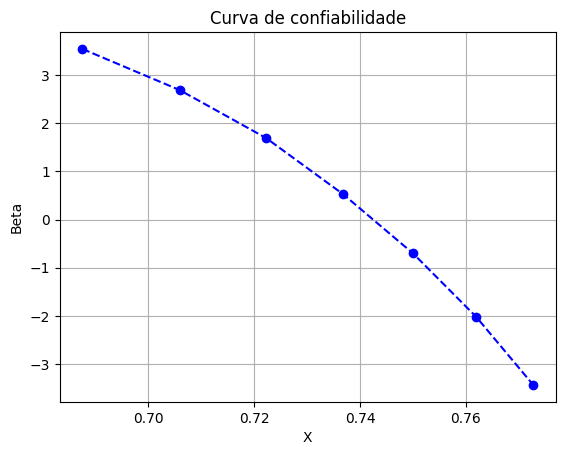

In [ ]:
plt.plot(chi, betas, 'bo--')
plt.grid()
plt.title('Curva de confiabilidade')
plt.xlabel('X')
plt.ylabel('Beta')